# Slayer for Image Recognition using CIFAR-10

## Lava installation

In [ ]:
!pip install git+https://github.com/lava-nc/lava-dl

  Cloning https://github.com/lava-nc/lava-dl to /tmp/pip-req-build-6_gjn7yd
  Running command git clone --filter=blob:none --quiet https://github.com/lava-nc/lava-dl /tmp/pip-req-build-6_gjn7yd
  Resolved https://github.com/lava-nc/lava-dl to commit eea9ce9ceb4c03ccb72a37883a38d3f48f0878d4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/lava-nc/lava.git (to revision main) to /tmp/pip-install-1zt3zgcf/lava-nc_426987924b5b4f56905beea35a2d69bc
  Running command git clone --filter=blob:none --quiet https://github.com/lava-nc/lava.git /tmp/pip-install-1zt3zgcf/lava-nc_426987924b5b4f56905beea35a2d69bc
  Resolved https://github.com/lava-nc/lava.git to commit 6aabc0eb243f46a7bbf94ef0e0eb0f2c84efe210
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.to

In [ ]:
!pip install gitpython
from IPython.display import clear_output
clear_output()

import os, shutil
from git import Repo

try:
    # Check if this cell is running in google colab
    import google.colab

    # Delete everything in the content (current) directory on google colab
    for root, dirs, files in os.walk("/content"):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            shutil.rmtree(os.path.join(root, name))
        break

    # Clone git repo, change the branch and
    Repo.clone_from("https://github.com/lava-nc/lava-dl", "/content/lava-dl")

    # Move the repo up by one level in the folder hierarchy
    for root, dirs, files in os.walk("/content/lava-dl"):
        for name in dirs + files:
            shutil.move(os.path.join(root, name), os.path.join("/content", name))
        break
    os.rmdir("/content/lava-dl")

except:
    print("This cell is only supposed to be executed on google colab, not on your local machine!")

In [ ]:
import os, sys
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import IPython.display as display
from matplotlib import animation

import lava.lib.dl.slayer as slayer


## Network Definition

In [ ]:

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}

        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 648, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, 512, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 10, weight_norm=True),
            ])

    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike

    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad
    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

## Data Import

### Original download

In [ ]:
#! pip install spikingjelly

In [ ]:
#from spikingjelly.datasets import cifar10_dvs
#from spikingjelly.datasets import split_to_train_test_set

In [ ]:
#dataset = cifar10_dvs.CIFAR10DVS('/content/CIFAR', data_type = 'frame', frames_number = 10, split_by = 'number',
#transform = None, target_transform = None)

In [ ]:
#train_dataset, val_dataset  = split_to_train_test_set(train_ratio = 0.7, origin_dataset = dataset, num_classes= 10)

In [ ]:
#torch.save(val_dataset, '/content/drive/MyDrive/CIFAR/val_dataset.pth')

In [ ]:
#!zip -r /content/CIFAR/events_np.zip /content/CIFAR/events_np

### Reimport

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_filename = '/content/drive/MyDrive/events_np.zip'
extract_folder = '/content/events_np'

!unzip {zip_filename} -d {extract_folder}

Streaming output truncated to the last 5000 lines.
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_35.npz  
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_666.npz  
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_886.npz  
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_593.npz  
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_924.npz  
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_734.npz  
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_135.npz  
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_12.npz  
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_467.npz  
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_353.npz  
  inflating: /content/events_np/content/CIFAR/events_np/ship/cifar10_ship_822.npz  
  inflating: /content/event

### Dataset Definition

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# same transformation as used in the lava mnist tutorial
def augment(event):
    x_shift = 4
    y_shift = 4
    theta = 10
    xjitter = np.random.randint(2*x_shift) - x_shift
    yjitter = np.random.randint(2*y_shift) - y_shift
    ajitter = (np.random.rand() - 0.5) * theta / 180 * 3.141592654
    sin_theta = np.sin(ajitter)
    cos_theta = np.cos(ajitter)
    event.x = event.x * cos_theta - event.y * sin_theta + xjitter
    event.y = event.x * sin_theta + event.y * cos_theta + yjitter
    return event


class CIFARDataset(Dataset):
    """CIFAR dataset method

    Parameters
    ----------
    path : str, optional
        path of dataset root, by default 'data'
    train : bool, optional
        train/test flag, by default True
    sampling_time : int, optional
        sampling time of event data, by default 1
    sample_length : int, optional
        length of sample data, by default 300
    transform : None or lambda or fx-ptr, optional
        transformation method. None means no transform. By default Noney.
    download : bool, optional
        enable/disable automatic download, by default True
    """
    def __init__(
        self, path='data',
        train=True,
        sampling_time=20, sample_length=8000,
        transform=None, download=True,
    ):
        super(CIFARDataset, self).__init__()
        self.path = path
        self.classes, self.class_to_idx = self._find_classes()
        if train:
            data_path = "/content/events_np/content/CIFAR/events_np"

        self.samples = self._make_dataset()

        self.sampling_time = sampling_time
        self.num_time_bins = int(sample_length/sampling_time)
        self.transform = transform

    def _find_classes(self):

        classes = [d for d in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def _make_dataset(self):
        # Create a list of file paths and their corresponding labels
        samples = []
        for target_class in self.classes:
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(self.path, target_class)
            for root, _, fnames in sorted(os.walk(target_dir)):
                for fname in fnames:
                    path = os.path.join(root, fname)
                    item = (path, class_index)
                    samples.append(item)
        return samples

    def __getitem__(self, i):
        filename, label = self.samples[i]
        ev = np.load(filename)
        event = slayer.io.Event(t_event = ev['t'], y_event = ev['y'], x_event = ev['x'], c_event = np.zeros_like(ev['x']))

        if self.transform is not None:
            event = self.transform(event)

        spike = event.fill_tensor(
                torch.zeros(2, 128, 128, self.num_time_bins),
                sampling_time=self.sampling_time,
            )
        spike_reshaped = np.moveaxis(np.array(spike), 1, -1)
        spike_reshaped = np.moveaxis(spike_reshaped, 1, -1)
        # Perform average pooling only along the last two dimensions
        spike_pooled = F.avg_pool2d(torch.tensor(spike_reshaped), kernel_size=7, stride=7, padding=0).numpy()
        # Reshape back to the original shape
        spike_pooled = np.moveaxis(spike_pooled, -1, 1)
        spike_pooled = np.moveaxis(spike_pooled, -1, 1)
        spike_pooled = spike_pooled.reshape(-1, np.shape(spike_pooled)[3])
        # ensure that spikes are still all-or-none responses after averaging
        spike_pooled =  torch.tensor(np.where(spike_pooled > 0, 1.0, 0.0), dtype=torch.float32)

        return spike_pooled, label

    def __len__(self):
        return len(self.samples)

In [ ]:
# path to the data
path = "/content/events_np/content/CIFAR/events_np"
cifar_dataset = CIFARDataset(path, train=True, transform = augment)


In [ ]:
import tqdm
import math
import numpy as np

# spikingjelly split_to_train_test_set function
def split_to_train_test_set(train_ratio: float, origin_dataset: torch.utils.data.Dataset, num_classes: int, random_split: bool = False):
    '''
    :param train_ratio: split the ratio of the origin dataset as the train set
    :type train_ratio: float
    :param origin_dataset: the origin dataset
    :type origin_dataset: torch.utils.data.Dataset
    :param num_classes: total classes number, e.g., ``10`` for the MNIST dataset
    :type num_classes: int
    :param random_split: If ``False``, the front ratio of samples in each classes will
            be included in train set, while the reset will be included in test set.
            If ``True``, this function will split samples in each classes randomly. The randomness is controlled by
            ``numpy.random.seed``
    :type random_split: int
    :return: a tuple ``(train_set, test_set)``
    :rtype: tuple
    '''
    label_idx = []
    for i in range(num_classes):
        label_idx.append([])

    for i, item in enumerate(tqdm.tqdm(origin_dataset)):

        y = item[1]

        if isinstance(y, np.ndarray) or isinstance(y, torch.Tensor):
            y = y.item()
        label_idx[y].append(i)
    train_idx = []
    test_idx = []
    if random_split:
        for i in range(num_classes):
            np.random.shuffle(label_idx[i])

    for i in range(num_classes):
        pos = math.ceil(label_idx[i].__len__() * train_ratio)
        train_idx.extend(label_idx[i][0: pos])
        test_idx.extend(label_idx[i][pos: label_idx[i].__len__()])

    return torch.utils.data.Subset(origin_dataset, train_idx), torch.utils.data.Subset(origin_dataset, test_idx)

In [ ]:
! pip install spikingjelly

In [ ]:
from spikingjelly import datasets

In [ ]:
training_set, testing_validation_set = datasets.split_to_train_test_set(0.7, cifar_dataset, 10)

100%|██████████| 10000/10000 [23:08<00:00,  7.20it/s]


In [ ]:
# Reimport data split
# import torch
# training_set = torch.load("train_set_full.pt")
# testing_validation_set = torch.load("test_val_set_full.pt")

## Network Instantiation

In [ ]:
import time
from torch.utils.data import Subset, random_split
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

device = torch.device('cuda')
# Get wakeup time
start_time = time.time()
net = Network().to(device)
end_time = time.time()
wakeup_time = end_time - start_time
print(f"Wakeup time: {wakeup_time:.4f} seconds")

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
subset_size = len(testing_validation_set)
subset1_size = subset_size // 2
subset2_size = subset_size - subset1_size

val_set, testing_set = random_split(testing_validation_set, [subset1_size, subset2_size])
train_loader = DataLoader(dataset=training_set, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=64, shuffle=True)

Wakeup time: 5.0204 seconds


In [ ]:
error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

## Network Training

In [ ]:
import time

import tracemalloc
start_time = time.time()
tracemalloc.start()

def train_one_epoch(epoch, epochs):
      for i, (input, label) in enumerate(train_loader):
          output = assistant.train(input, label)

      print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

      latency_sum = 0
      num_batches = 0
      troughput_start_time = time.time()
      for i, (input, label) in enumerate(val_loader):

            start_time = time.time()

            # Inference without gradient calculation
            with torch.no_grad():
                output = assistant.test(input, label)

            end_time = time.time()

            # Measure and accumulate latency for each test batch
            latency_batch = end_time - start_time
            latency_sum += latency_batch
            num_batches += 1
      troughput_end_time = time.time()
      print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
      print('\n')
      average_latency = latency_sum / num_batches if num_batches > 0 else 0
      throughput_time = troughput_end_time - troughput_start_time
      throughput = num_batches / throughput_time if throughput_time > 0 else 0
      print(f'[Epoch {epoch}/{epochs}] Average Latency: {average_latency:.4f} seconds')
      print('\n')
      if epoch%20 == 19: # cleanup display
          print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
          stats_str = str(stats).replace("| ", "\n")
          print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')

      torch.save(net.state_dict(), trained_folder + f'/network_epoch{epoch}.pt')

      if stats.testing.best_accuracy:
        torch.save(net.state_dict(), trained_folder + f'/network.pt')

      stats.update()
      stats.save(trained_folder + '/')
      net.grad_flow(trained_folder + '/')
      return average_latency, throughput

# End measuring time
memory_per_episode = []
episodes= 15

epoch_latency = []
epoch_throughputs = []
for epoch in range(1, episodes+1):
  tracemalloc.start()
  latency, throughput = train_one_epoch(epoch, episodes)
  epoch_latency.append(latency)
  epoch_throughputs.append(throughput)
  snapshot = tracemalloc.take_snapshot()
  tracemalloc.stop()
  epoch_size = 0
  for line_stat in snapshot.statistics('lineno'):
    epoch_size += line_stat.size

  memory_per_episode.append(epoch_size)

end_time = time.time()

# Calculate elapsed time
elapsed_time_training = end_time - start_time
print(f"Average Latency over all epochs: ", np.average(epoch_latency))
print(f"Average Throughput over all epochs: ", np.average(epoch_throughputs))
print(f"Average memory attributed per epoch: {np.average(memory_per_episode)/ 1e6} MBit with standard deviation: {np.std(memory_per_episode)/ 1e3} KBit")
print(f"Total training time: {elapsed_time_training} seconds")


[Epoch  1/15] Train loss =     2.47660                          accuracy = 0.12143  | Test  loss =     2.20877                          accuracy = 0.14000 

[Epoch 1/15] Average Latency: 0.0973 seconds


[Epoch  2/15] Train loss =     2.06068 (min =     2.47660)     accuracy = 0.14671 (max = 0.12143)  | Test  loss =     1.92857 (min =     2.20877)     accuracy = 0.14000 (max = 0.14000) 

[Epoch 2/15] Average Latency: 0.0978 seconds


[Epoch  3/15] Train loss =     1.97594 (min =     2.06068)     accuracy = 0.15057 (max = 0.14671)  | Test  loss =     1.92256 (min =     1.92857)     accuracy = 0.13467 (max = 0.14000) 

[Epoch 3/15] Average Latency: 0.0983 seconds


[Epoch  4/15] Train loss =     2.01480 (min =     1.97594)     accuracy = 0.14671 (max = 0.15057)  | Test  loss =     1.86726 (min =     1.92256)     accuracy = 0.16000 (max = 0.14000) 

[Epoch 4/15] Average Latency: 0.0984 seconds


[Epoch  5/15] Train loss =     1.94047 (min =     1.97594)     accuracy = 0.16229 (max = 0.150

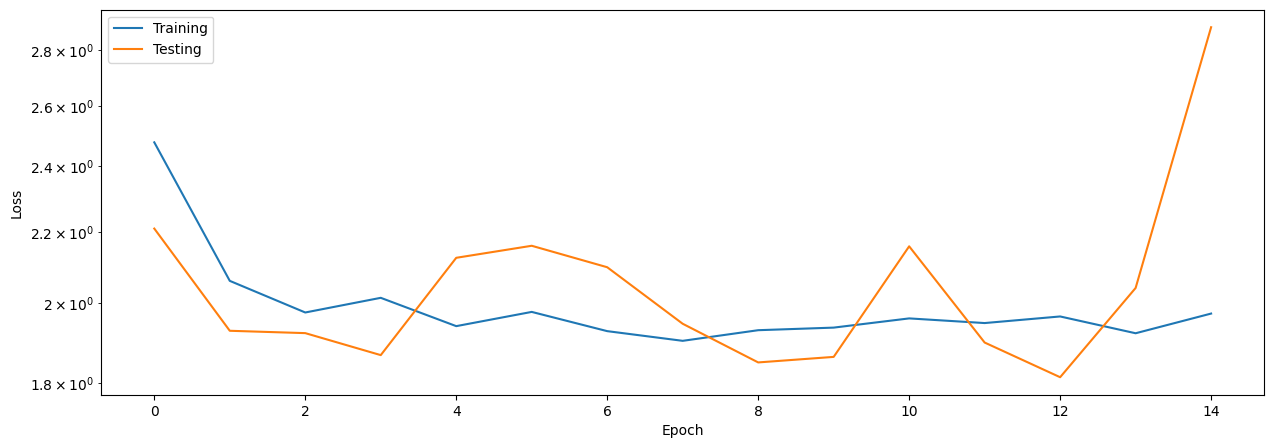

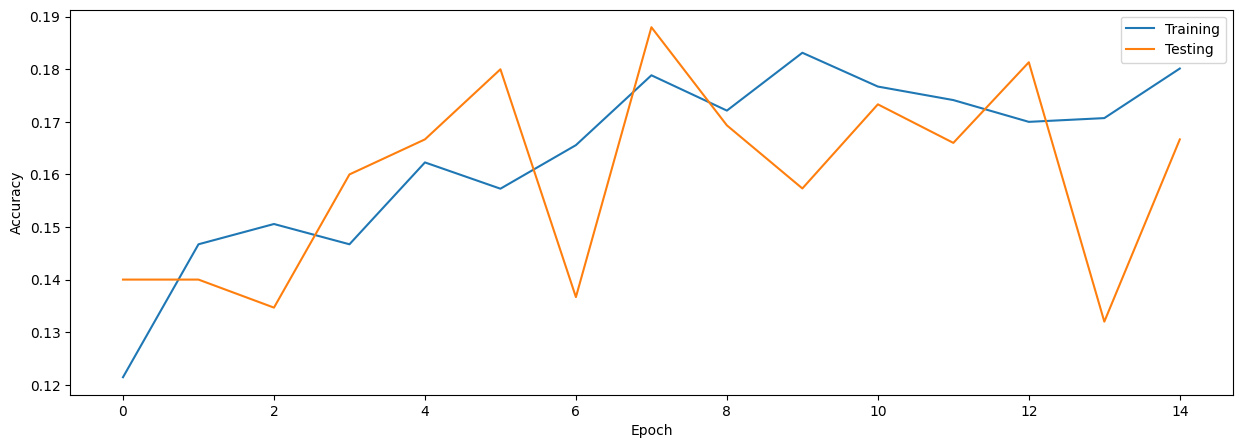

In [ ]:
stats.plot(figsize=(15, 5))

## Network Testing

In [ ]:
import time

import tracemalloc
start_time = time.time()
tracemalloc.start()

def test():
      latency_sum = 0
      num_batches = 0
      troughput_start_time = time.time()
      for i, (input, label) in enumerate(test_loader):

            start_time = time.time()

            # Inference without gradient calculation
            with torch.no_grad():
                output = assistant.test(input, label)

            end_time = time.time()

            # Measure and accumulate latency for each test batch
            latency_batch = end_time - start_time
            latency_sum += latency_batch
            num_batches += 1
      troughput_end_time = time.time()

      average_latency = latency_sum / num_batches if num_batches > 0 else 0
      throughput_time = troughput_end_time - troughput_start_time
      throughput = num_batches / throughput_time if throughput_time > 0 else 0


      return average_latency, throughput

# End measuring time
memory_testing = []


epoch_latency = []
epoch_throughputs = []

tracemalloc.start()
latency, throughput = test()
snapshot = tracemalloc.take_snapshot()
tracemalloc.stop()
memory_size = 0
for line_stat in snapshot.statistics('lineno'):
  memory_size += line_stat.size


end_time = time.time()

# Calculate elapsed time
elapsed_time_testing = end_time - start_time
print(f'Average Latency: {latency:.4f} seconds')
print(f"Average Throughput: ", throughput)
print(f"Average memory attributed for testing: {memory_size/ 1e6} MBit with standard deviation: {memory_size/ 1e3} KBit")
print(f"Total testing time: {elapsed_time_testing} seconds")

Average Latency: 0.1002 seconds
Average Throughput:  0.11102957664233558
Average memory attributed for testing: 0.309349 MBit with standard deviation: 309.349 KBit
Total testing time: 216.1721179485321 seconds


In [ ]:
all_labels = []
all_preds= []

for i, (input, label) in enumerate(test_loader): # test loop
        output = assistant.test(input, label)
        pred = slayer.classifier.Rate.predict(output)
        all_labels.append(pred)
        all_preds.append(label)


In [ ]:
def download_as_tensor(filename, list):
  flat_all_labels = []
  for tensor in list:
    for tensor2 in tensor:
        flat_all_labels.append(tensor2.cpu().numpy())
  flat_all_labels = np.array(flat_all_labels).flatten()
  torch.save(flat_all_labels, filename)

In [ ]:
download_as_tensor('all_labels.pt', all_labels)
download_as_tensor('all_preds.pt', all_preds)

###Accuracy Metrics


In [2]:
import torch
all_labels = torch.load('all_labels.pt')
all_preds = torch.load('all_preds.pt')

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(all_labels,all_preds))

Accuracy:  0.172


In [6]:
from sklearn.metrics import recall_score
import numpy as np
def get_recall(y_true, preds):
  for j in range(0,9):
    binary_y_true = np.zeros(len(y_true))
    preds_binary = np.zeros(len(y_true))
    for i in range(len(y_true)):
      if (y_true[i] == j):
        binary_y_true[i] = 1
      if (preds[i] == j):
        preds_binary[i] = 1

  return recall_score(binary_y_true,preds_binary)
print("Recall: ", get_recall(all_labels,all_preds))

Recall:  0.2545454545454545


In [8]:
from sklearn.metrics import f1_score
f1 = f1_score(all_labels, all_preds, average='macro')
print(f'F1 Score: {f1}')

F1 Score: 0.10858622498688666


Text(0.5, 1.0, 'ROC Curve')

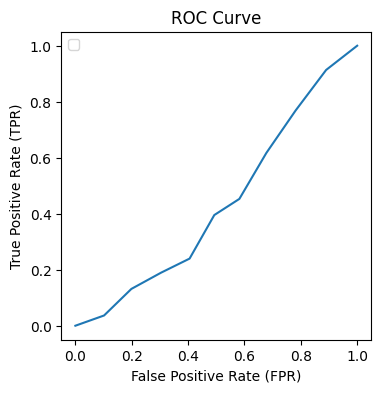

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

roc_fpr = []
roc_tpr = []

for i in range(0,9):
  fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label = i)
  roc_fpr.append(fpr)
  roc_tpr.append(tpr)

plt.figure(figsize=(4, 4))
plt.plot(np.average(roc_fpr, axis = 0), np.average(roc_tpr, axis = 0))

plt.legend()

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')


In [ ]:
def get_AUC(y_true, preds):
  for j in range(0,9):
    binary_y_true = np.zeros(len(y_true))
    preds_binary = np.zeros(len(y_true))
    for i in range(len(y_true)):
      if (y_true[i] == j):
        binary_y_true[i] = 1
      if (preds[i] == j):
        preds_binary[i] = 1

  return roc_auc_score(binary_y_true, preds_binary)

auc = get_AUC(all_labels, all_preds)
print(f'AUC: {auc}')

AUC: 0.5829820698332808


In [ ]:
def get_TRP_FRP(y_true, preds):
  confusion = confusion_matrix(y_true, preds)

  TRPs_Decolle = []
  for class_index in range(0,9):
    TP = confusion[class_index, class_index]
    FN = np.sum(confusion[class_index, :]) - TP

    TRPs_Decolle.append(TP / (TP + FN))

  FRPs_Decolle = []
  for class_index in range(0,9):
    FP = confusion[class_index, class_index]
    TN = np.sum(confusion) - np.sum(confusion[class_index, :]) - np.sum(confusion[:, class_index]) + FP

    FRPs_Decolle.append(TP / (TP + FN))

  return str(np.average(TRPs_Decolle)), str(np.average(FRPs_Decolle))

trp_decolle, frp_decolle = get_TRP_FRP(all_labels,all_preds)
print('Average true positive rate: ' + trp_decolle)
print('Average false positive rate: ' + frp_decolle)

Average true positive rate: 0.14949805391114848
Average false positive rate: 0.2545454545454545


In [ ]:
def true_negative_rate(y_true, y_pred):
    # Assuming y_true and y_pred are arrays/lists of true labels and predicted labels, respectively.
    tn = sum((y_true == 0) & (y_pred == 0))  # True negatives
    fp = sum((y_true == 0) & (y_pred == 1))  # False positives

    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0.0  # True Negative Rate (Specificity)

    return tnr
tnr = true_negative_rate(all_labels, all_preds)
print("True Negative Rate:", tnr)

True Negative Rate: 0.7619047619047619


In [ ]:
from sklearn.metrics import average_precision_score
def get_precision(y_true, preds):
  for j in range(0,9):
    binary_y_true = np.zeros(len(y_true))
    preds_binary = np.zeros(len(y_true))
    for i in range(len(y_true)):
      if (y_true[i] == j):
        binary_y_true[i] = 1
      if (preds[i] == j):
        preds_binary[i] = 1

  return average_precision_score(binary_y_true,preds_binary)

print("Average precision: ", get_precision(all_labels,all_preds))

Average precision:  0.05242936406316688


## Metrics

### Energy
**Energy Consumption Metric:** This metric assesses the average energy usage for both wake-up time and training time while running the model in Google Colab.

These measurements are based on average times, as referenced from the specific energy consumption www.green-algorithms.org website (Energy Consumption for 1 Google Cloud GPU). These values are estimates and provide a general overview of energy usage due to the varied nature of tasks and hardware configurations in cloud-based environments.

In [ ]:
# Definition of Average Power Usage
# Average power usage in watts (Based on the green-algorithms.org)
# Google Cloud GPU NVIDIA Tesla T4 Memory Available 16 GB per 1 hour will give 82.80 Wh per hour
average_power_usage_watts = 82.80

# Calculate energy consumption for wakeup time in Joules
energy_consumption_wakeup_Joules = average_power_usage_watts * wakeup_time
print(f"Estimated energy consumption for wakeup: {energy_consumption_wakeup_Joules} Joules")

Estimated energy consumption for wakeup: 415.68912 Joules


In [ ]:
# Calculate energy consumption for training in Joules
energy_consumption_training_testing_Joules = average_power_usage_watts * elapsed_time_training
print(f"Estimated energy consumption for training: {energy_consumption_training_testing_Joules} Joules")

Estimated energy consumption for training: 1493996.6897111891 Joules


In [ ]:
# Calculate energy consumption for testing in Joules
energy_consumption_testing_Joules = average_power_usage_watts * elapsed_time_testing
print(f"Estimated energy consumption testing: {energy_consumption_testing_Joules} Joules")

Estimated energy consumption testing: 17899.051366138458 Joules


In [ ]:
total_energy_consumption_Joules = energy_consumption_wakeup_Joules + energy_consumption_testing_Joules + energy_consumption_training_testing_Joules
print(f"Total estimated energy consumption: {total_energy_consumption_Joules} Joules")

Total estimated energy consumption: 1512311.4301973276 Joules


### Memory

* **On-Chip Memory Size**: in megabytes in the hardware specifications or documentation of the GPUs and neuromorphic chips we are comparing. This information should be available in the technical specifications of the hardware used.

* **Average Memory Attributed per Epoch**: The memory_per_episode list in the code below contains the memory attributed for each epoch. You can calculate the average memory attributed per epoch by taking the mean of this list.

other key metrics related to space utilization and computational efficiency:

* Model Size: size of neural network model. This includes the size of all the parameters (weights and biases) in the model. This can be obtained by saving the model's state dictionary and measuring its size.

* Parameters Utilization: Calculate the utilization of model parameters. This is the ratio of the actual on-chip memory used by the model parameters to the total available on-chip memory.

* Throughput and Latency: These metrics provide insights into the speed and efficiency of the model during both training and inference. You already have code for calculating throughput in your training loop.

In [ ]:
import numpy as np

# Assuming memory_per_episode is a list containing memory attributed for each epoch
average_memory_per_epoch = np.average(memory_per_episode) / 1e6  # in Megabytes

# Optionally, you can calculate the standard deviation
std_memory_per_epoch = np.std(memory_per_episode) / 1e6  # in Megabytes

print(f"Average Memory Attributed per Epoch: {average_memory_per_epoch:.2f} MB")
print(f"Standard Deviation of Memory Attributed per Epoch: {std_memory_per_epoch:.2f} MB")


Average Memory Attributed per Epoch: 3.31 MB
Standard Deviation of Memory Attributed per Epoch: 0.94 MB


In [ ]:
print(f"Average memory attributed for testing: {memory_size/ 1e6} MBit with standard deviation: {memory_size/ 1e3} KBit")

Average memory attributed for testing: 0.309349 MBit with standard deviation: 309.349 KBit


In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Get the GPU device name
    gpu_name = torch.cuda.get_device_name(0)

    # Get the total GPU memory
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to gigabytes

    print(f"GPU Name: {gpu_name}")
    print(f"Total GPU Memory: {gpu_memory:.2f} GB")
else:
    print("GPU not available.")


GPU Name: Tesla T4
Total GPU Memory: 15.84 GB


In [ ]:
# Assuming 'state_dict' is your loaded state dictionary
state_dict = torch.load("/content/Trained/network.pt")

# Calculate the model size based on the state dictionary
model_size_bytes = sum(tensor.numel() * tensor.element_size() for tensor in state_dict.values())
model_size_MB = model_size_bytes / (1024 ** 2)  # Convert to Megabytes

print(f"Model Size: {model_size_MB:.2f} MB")

Model Size: 2.29 MB


In [ ]:
### Parameters utilization
on_chip_memory_size_MB = 15840.0  # Actual size of Tesla T4 GPU memory in megabytes

parameters_utilization = model_size_MB / on_chip_memory_size_MB * 100  # Percentage

print(f"Parameters Utilization: {parameters_utilization:.2f}%")



Parameters Utilization: 0.01%


In [ ]:
### Throughput and latency

average_inference_latency = np.average(epoch_latency)
average_inference_throughput = np.average(epoch_throughputs)

print(f"Average Inference Latency: {average_inference_latency:.4f} seconds")
print(f"Average Inference Throughput: {average_inference_throughput:.2f} batches per second")

Average Inference Latency: 0.0982 seconds
Average Inference Throughput: 0.11 batches per second


In [ ]:
print(f'Average Latency for Testing: {latency:.4f} seconds')
print(f"Average Throughput for Testing: ", throughput)

Average Latency for Testing: 0.1002 seconds
Average Throughput for Testing:  0.11102957664233558


In [ ]:
print(f"Total testing time: {elapsed_time} seconds")

Total testing time: 216.1721179485321 seconds
